<div class="alert alert-block alert-info">

## <center> GROUP PROJECT - TO GRANT OR NOT TO GRANT: DECIDING ON COMPENSATION BENEFITS </center> <br>
#  <center> <b> Feature Selection Strategy </center> <br>
## <center> Fall Semester 2024-2025 <center>
<br>
<center> Group 46: <center> <br>
<center>Afonso Ascensão, 20240684 <br><center>
<center>Duarte Marques, 20240522 <br><center>
<center>Joana Esteves, 20240746 <br><center>
<center>Rita Serra, 20240515 <br><center>
<center>Rodrigo Luís, 20240742 <br><center>

<div>

**Description of contents:**
- Apply pipeline to preprocess the data up to the scaling transformer.
- Define filter methods to implement for numeric and categoric features to remove irrelevant or redundant variables. Set thresholds to implement some of these methods in the pipeline.
- Define embedded methods to create rankings for feature importance and set thresholds to implement this methods in the pipeline.
- Define how the final ranking is calculated based on the individual rankings that result from embedded methods, in order to obtain the final set fo features to consider for the models.


**Table of Contents**
- [1. Import the needed Libraries](#section_1)
- [2. Import Dataset and Pipeline](#section_2)
- [3. Feature Selection](#section_3)
    - [3.1. Filter Methods](#section_3_1)
        - [3.1.1. Numerical variables](#section_3_1_1)
            - [3.1.1.1. Variance](#section_3_1_1_1)
            - [3.1.1.2. Spearman's](#section_3_1_1_2)
            - [3.1.1.3. Plots](#section_3_1_1_3)
        - [3.1.2. Categoric Variables](#section_3_1_2)
            - [3.1.2.1. Cramer's V](#section_3_1_2_1)
    - [3.2. Embedded Methods](#section_3_2)
        - [3.2.1. Lasso Regression](#section_3_2_1)
        - [3.2.2. Decision Tree](#section_3_2_2)
        - [3.2.3. XGBoost](#section_3_2_3)
    - [3.3. Final Ranking](#section_3_3)

<a class="anchor" id="section_1">

# 1. Import the needed Libraries

</a>

In [13]:
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import seaborn as sns


## Pipeline
from sklearn.pipeline import Pipeline
from joblib import load
from transformers import *
## Target encoding
from sklearn.preprocessing import LabelEncoder

# Feature selection
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from scipy.stats import chi2_contingency

# Define a seed
random_state = 42

# Display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)

<a class="anchor" id="section_2">

# 2. Import Dataset and Pipeline

</a>

In [2]:
# Load the transformed train and validation data from a Parquet file
transformed_train_split = pd.read_parquet('transformed_train_split.parquet')
transformed_val_split = pd.read_parquet("transformed_val_split.parquet")

In [3]:
# Load machine learning pipeline from a .joblib file
pipeline = load('pipeline.joblib') 

<a class="anchor" id="section_3">

# 3. Feature Selection

</a>

In [4]:
# Separate X and y for train after split
X_train = transformed_train_split.drop(['Claim Injury Type'], axis = 1)
y_train = transformed_train_split['Claim Injury Type']
y_train = y_train.values.ravel()

# Separate X and y for validation after split
X_val = transformed_val_split.drop(['Claim Injury Type'], axis = 1)
y_val = transformed_val_split['Claim Injury Type']

In [ ]:
# Target encoding
label_encoder = LabelEncoder()

# Encode target
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [5]:
# Apply preprocessing to the training data excluding the feature selection tranformer 
X_train_preprocessed = pipeline[:-1].fit_transform(X_train)
X_val_preprocessed = pipeline[:-1].transform(X_val)

In [7]:
# Separate numeric and categoric features 
metric_features=['Age at Injury', 'Average Weekly Wage', 'Carrier Name',
       'County of Injury', 'IME-4 Count',
       'Industry Code', 'Number of Dependents',
       'Accident Year', 'Assembly Year',
       'Average Weekly Wage Log', 'IME-4 Count Log',
       'Time Accident to Assembly', 'Time Assembly to Hearing',
       'Wage Age Ratio']

# Features that were originally numeric or that were encoded with frequency encoder
X_train_num = X_train_preprocessed[metric_features]

# Features that were originally binary or that were encoded with one hot encoder
X_train_cat = X_train_preprocessed.drop(columns = X_train_num.columns)


<a class="anchor" id="section_3_1">

## 3.1 Filter Methods

</a>

<a class="anchor" id="section_3_1_1">

### 3.1.1 Numerical Variables

</a>

<a class="anchor" id="section_3_1_1_1">

#### 3.1.1.1. Variance
    
</a>

In [10]:
#Check if any of the numerical variables is univariate (variance is equal to 0). Drop those variables if existent.
X_train_num.var()

Age at Injury                0.013477
Average Weekly Wage          0.000005
Carrier Name                 0.190836
County of Injury             0.092837
IME-4 Count                  0.000408
Industry Code                0.135380
Number of Dependents         0.111184
Accident Year                0.035621
Assembly Year                0.164195
Average Weekly Wage Log      0.001210
IME-4 Count Log              0.005504
Time Accident to Assembly    0.000782
Time Assembly to Hearing     0.010839
Wage Age Ratio               0.000004
dtype: float64

- `Average Weekly Wage Log` and `IME-4 Count log`: The log transformations slightly increase variance compared to the original features, which may improve the contributions to the model.
- `Wage Age Ratio`: Unlikely to contribute to model performance because it's nearly constant. We will remove this variables based the extremely low variance.

<a class="anchor" id="section_3_1_1_2">

#### 3.1.1.2. Spearman Correlation
    
</a>

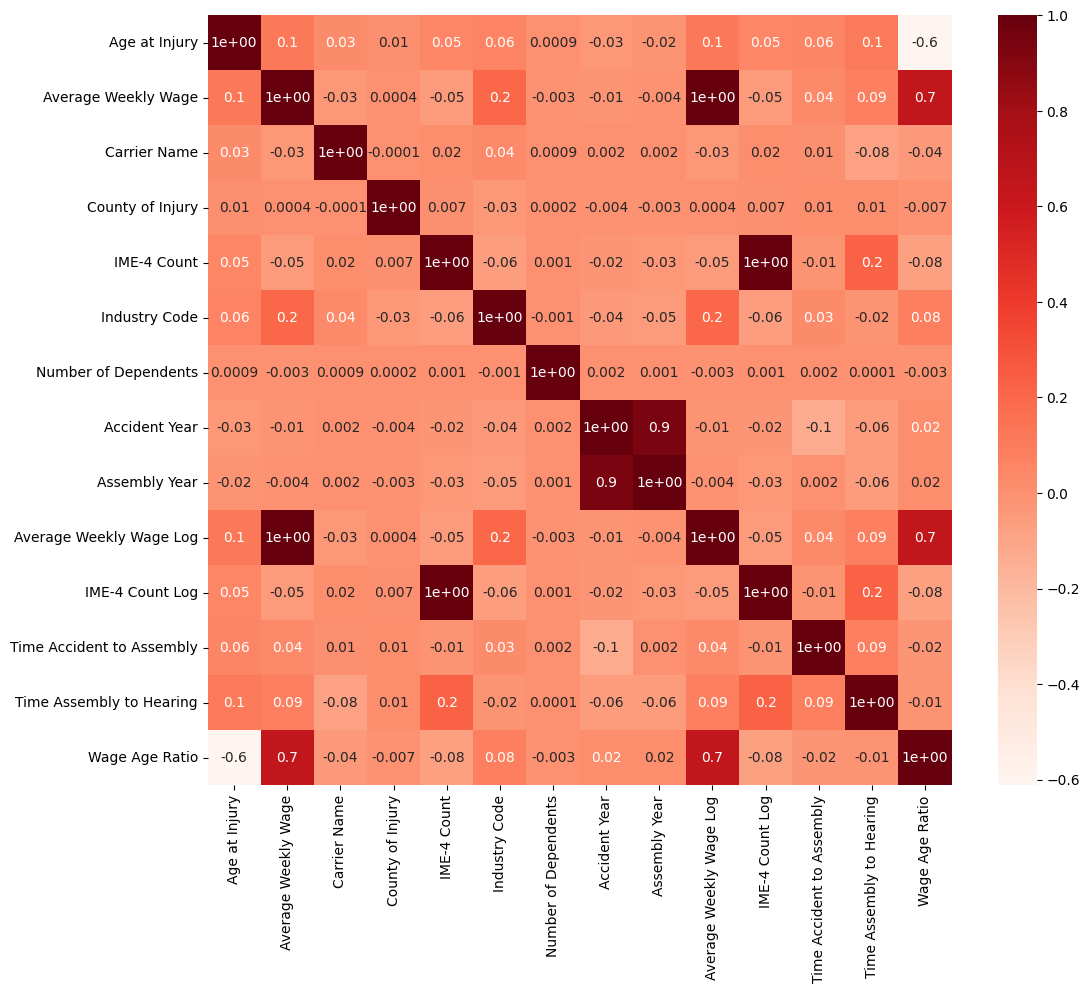

In [11]:
# Correlation of numeric features
cor_spearman = X_train_num.corr(method='spearman')

# Heatmap for correlation
plt.figure(figsize=(12,10))
sns.heatmap(cor_spearman, annot = True, cmap = plt.cm.Reds, fmt='.1')
plt.show()

**Threshold of above 0.8 for redudancy** - The Spearman correlation heatmap demonstrates that there are redundant variables:
- `Assembly Year` and `Accident Year` have a high correlation of 0.9, meaning they are strongly related to each other. Since these variables are so strongly correlated, they might be redundant in terms of the information they provide, and one of them could potentially be discarded without losing much valuable information.
- `Average Weekly Wage Log` and `Average Weekly Wage` have a correlation of 1: this indicates a perfect positive relationship. 
- `IME-4 Count` and `IME-4 Count Log` have a correlation of 1: this indicates a perfect positive relationship.

`Number of dependents`: This features does not seem correlated at all with the other features in the dataset, we will remove it to avoid noise.

<a class="anchor" id="section_3_1_1_4">

#### 3.1.1.4. Plots
    
</a>

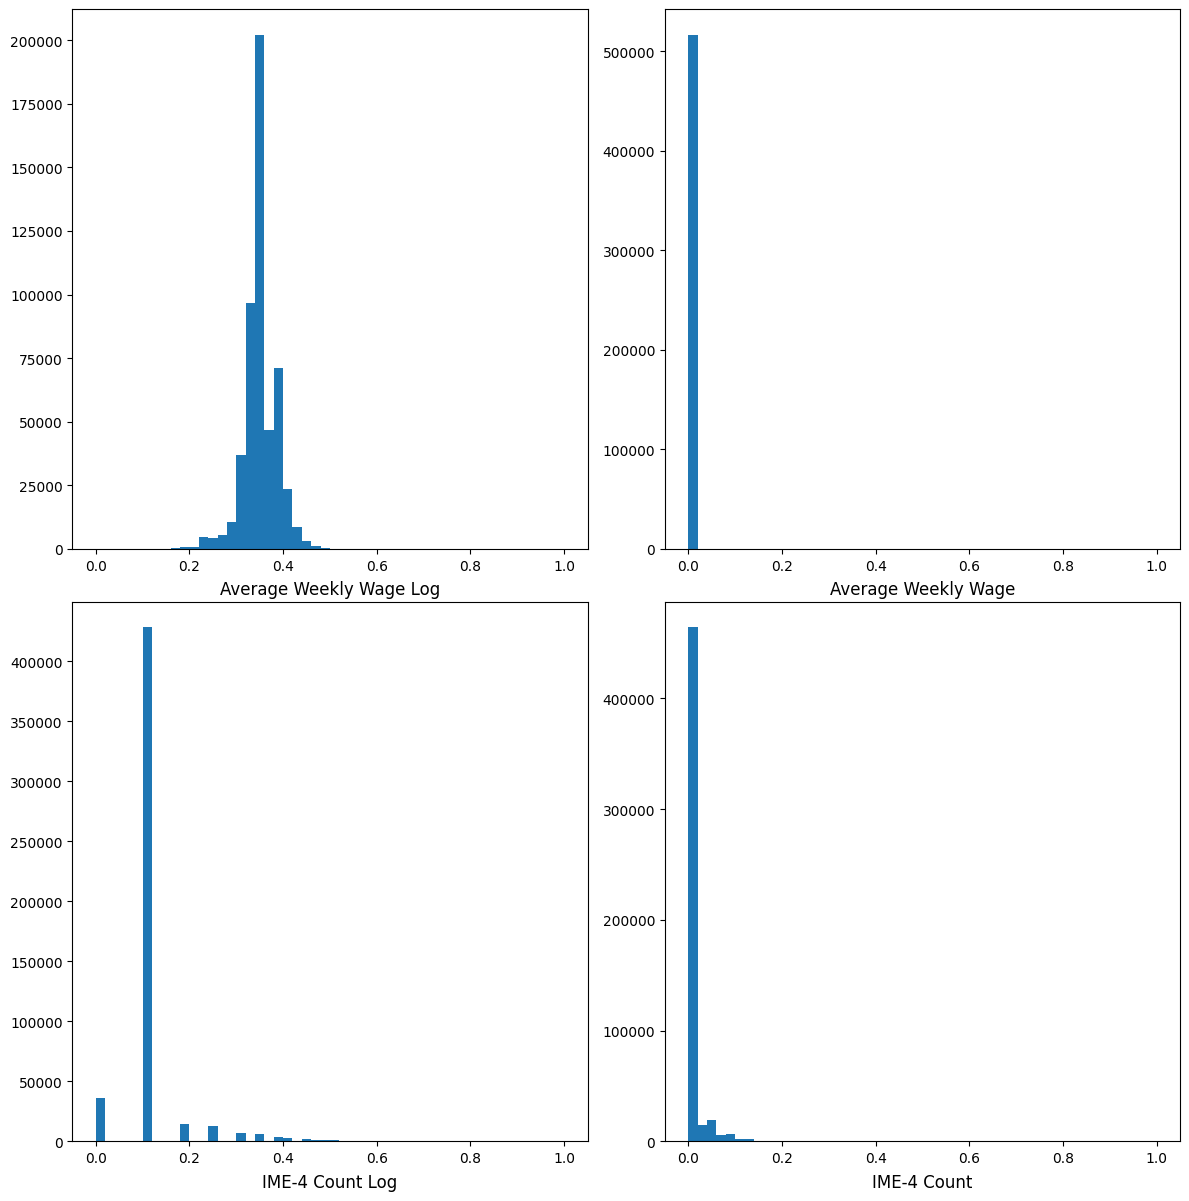

In [12]:
plt.figure(figsize=(12, 12)) 

plt.subplot(2, 2, 1)
plt.hist(X_train_num['Average Weekly Wage Log'], bins=50)  
plt.title("Average Weekly Wage Log", y=-0.1)


plt.subplot(2, 2, 2)
plt.hist(X_train_num['Average Weekly Wage'], bins=50)  
plt.title("Average Weekly Wage", y=-0.1)

plt.subplot(2, 2, 3)
plt.hist(X_train_num['IME-4 Count Log'], bins=50)  
plt.title("IME-4 Count Log", y=-0.1)

plt.subplot(2, 2, 4)
plt.hist(X_train_num['IME-4 Count'], bins=50)  
plt.title("IME-4 Count", y=-0.1)


plt.tight_layout()
plt.show()

- `IME-4 Count` and `Average Weekly Wage` VS. `IME-4 Count Log` and `Average Weekly Wage Log`: The logarithmic transformations help reduce the scale and the skewness of the distribution, as such it may be more beneficial to keep them and discard the variables IME-4 Count and Average Weekly Wage. We also saw that the log tranformation make the variance higher, which may improve predictive power.
- `Accident Year` VS. `Assembly Year`: Accident Year has a lower variance and had initially much more missing values than Assembly year, it also had wrong values that were inputed to correspond to the Assembly Year. After the missing values imputation and corrections the variable ended up being redundant so we will dicard it.

In [8]:
X_train_preprocessed = X_train_preprocessed.drop(["Average Weekly Wage", "IME-4 Count", "Accident Year", 
                                "Wage Age Ratio", "Number of Dependents"], axis=1)

<a class="anchor" id="section_3_1_2">

### 3.1.2 Categorical Variables

</a>

<a class="anchor" id="section_3_1_2_1">

#### 3.1.2.1. Cramer's V
    
</a>

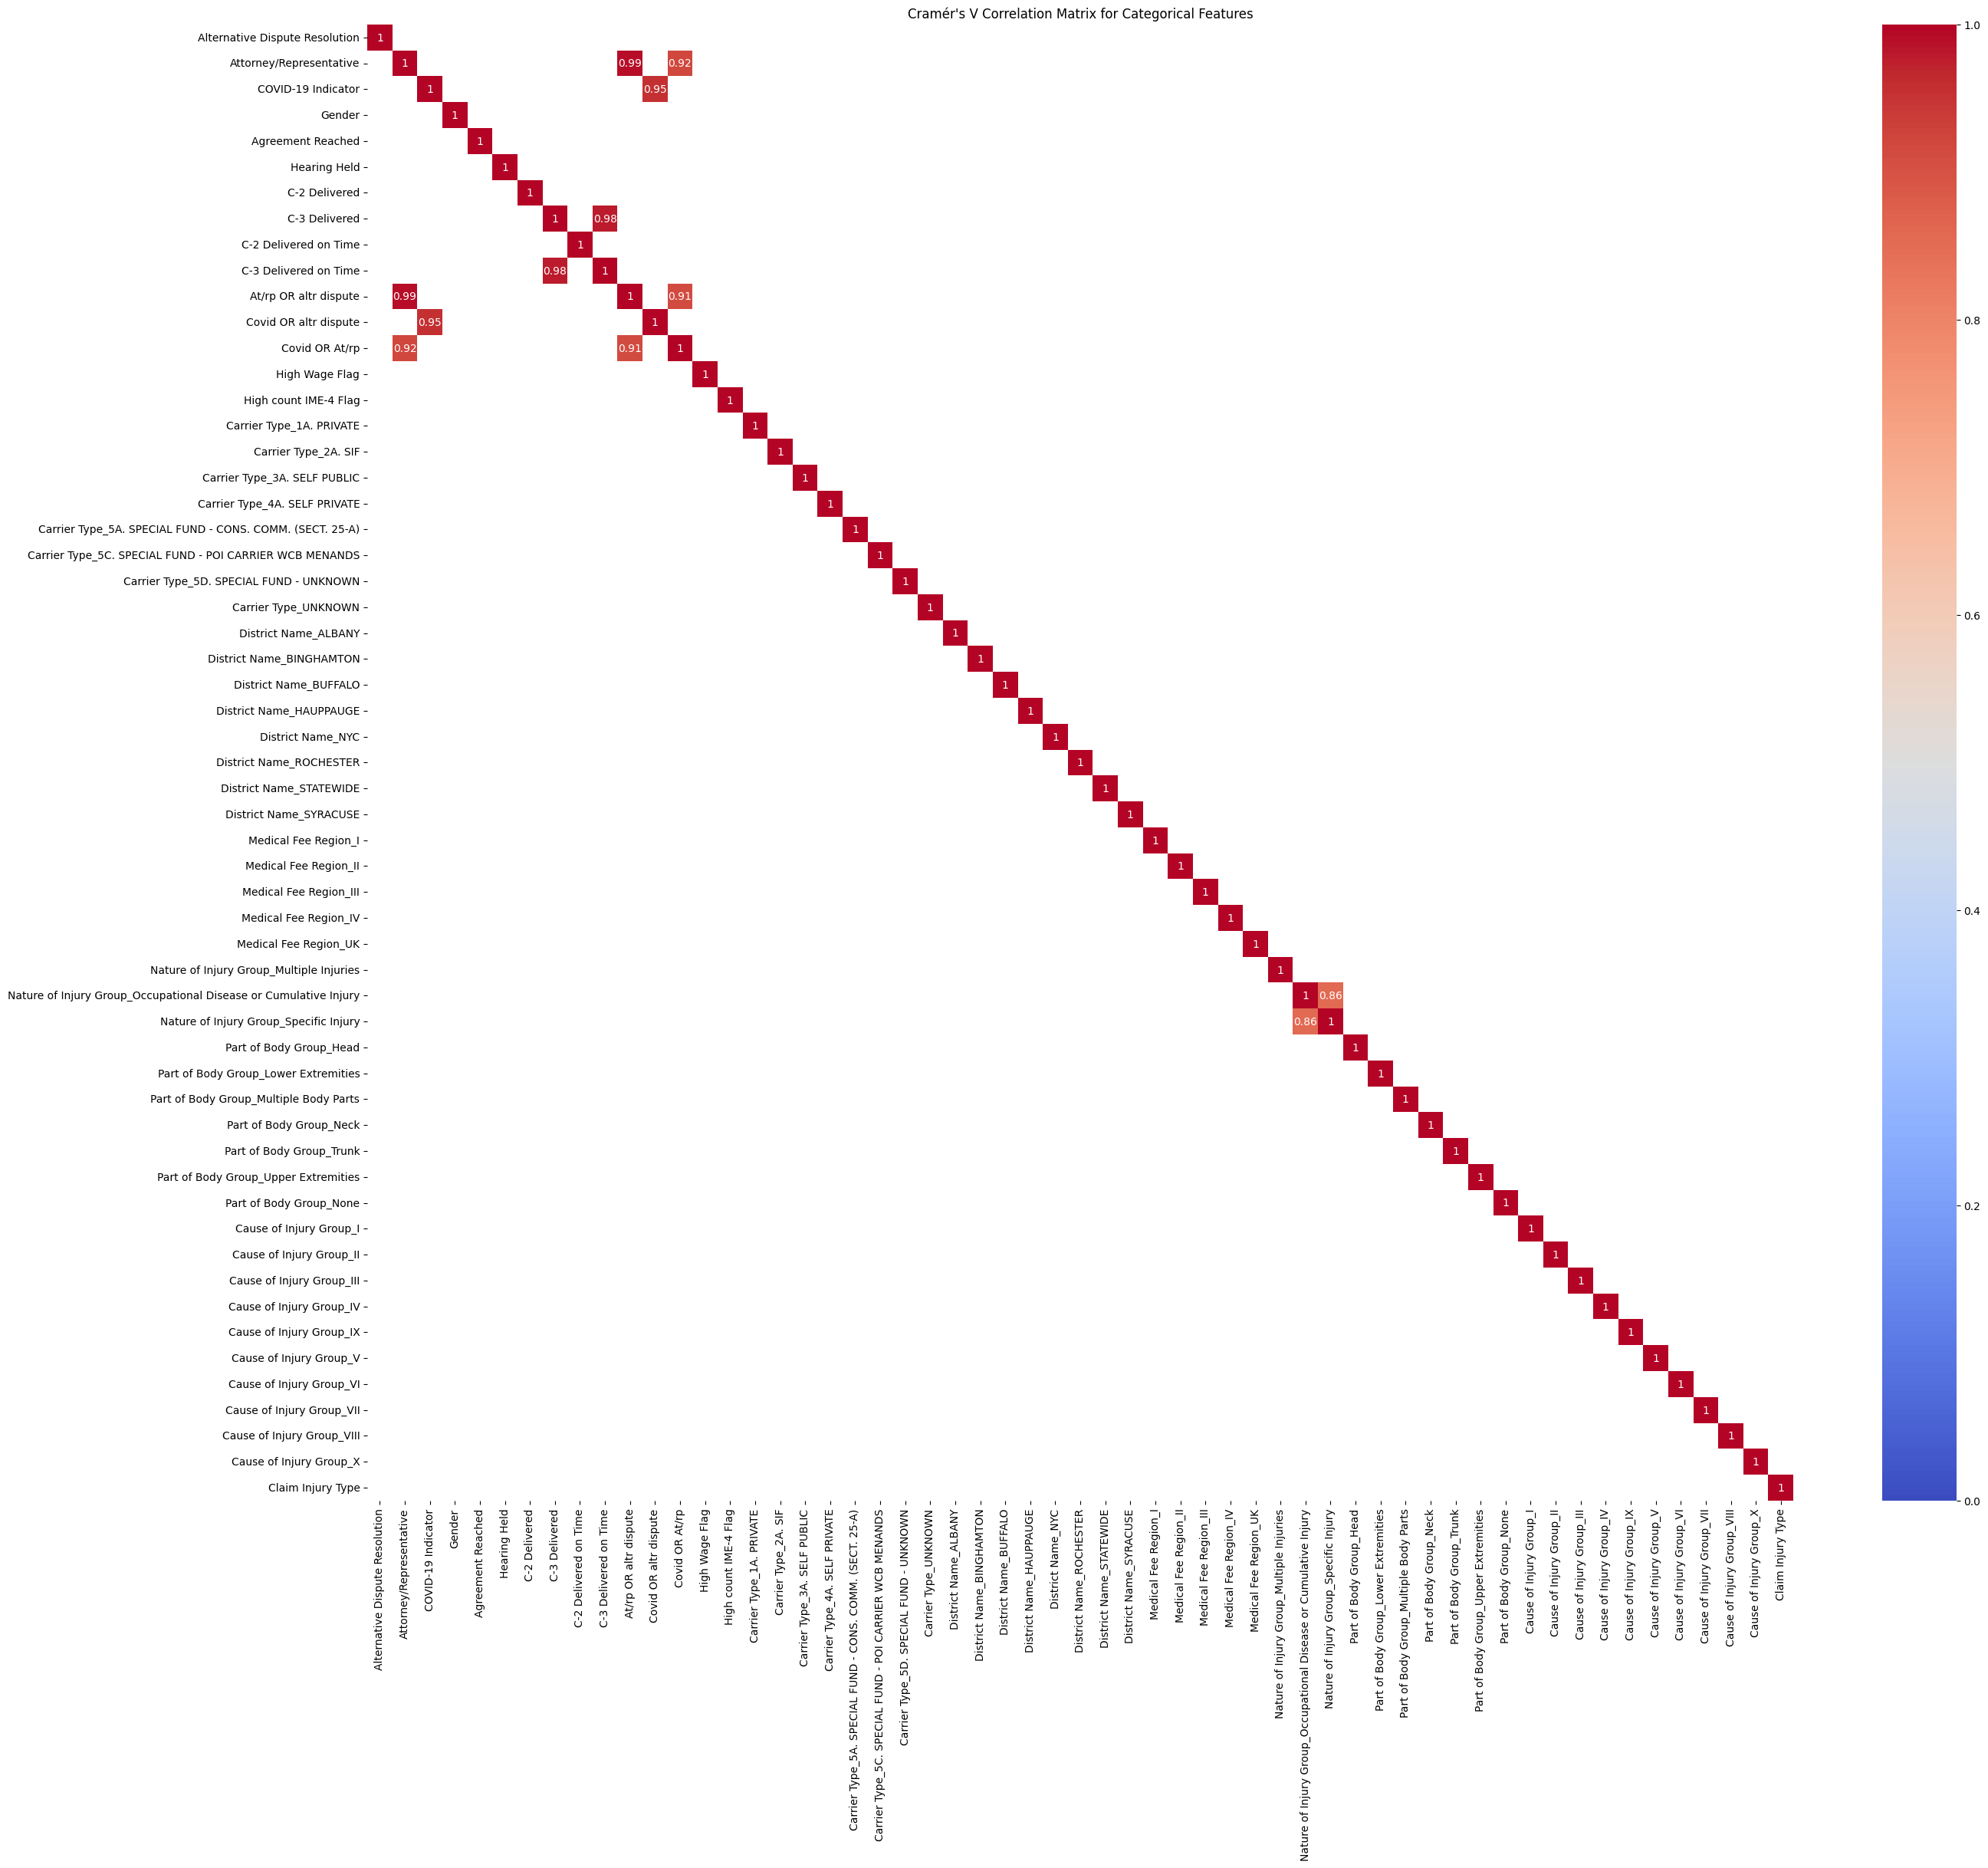

In [14]:
# Add the target variable to the non-metric features
data_non_metric = X_train_cat.copy()
data_non_metric['Claim Injury Type'] = y_train_encoded

def cramers_v(x, y):
    contingency = pd.crosstab(x, y).values
    chi2 = chi2_contingency(contingency, correction=False)[0]
    n = contingency.sum()
    r, k = contingency.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

def calculate_cramers_v_matrix(df):
    cols = df.columns
    n = len(cols)
    matrix = np.eye(n)  # Diagonal initialized to 1
    
    for i in range(n):
        for j in range(i + 1, n):  # Only calculate upper triangle
            v = cramers_v(df[cols[i]], df[cols[j]])
            matrix[i, j] = matrix[j, i] = v 
    return pd.DataFrame(matrix, columns=cols, index=cols)

# Calculate Cramér's V correlation matrix
cramers_v_matrix = calculate_cramers_v_matrix(data_non_metric)

# Threhold for redundancy 0.8

mask = ~(cramers_v_matrix > 0.8) 
# Plot the heatmap
plt.figure(figsize=(30, 25)) 
sns.heatmap(cramers_v_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cramér's V Correlation Matrix for Categorical Features")
plt.show()

**Threshold of above 0.8 for redudancy** - The Cramér's V matrix demonstrates that there are redundant variables:
- `C_3 Delivered` and `C_3 Delivered on Time`  have a correlation of 0.98.
- `Attorney/Representative` has a high correlation with `At/rp Or altr dispute` (0.99) and `Covir Or At/rp`.
- `COVID-19 Indicator` e `Covid Or altr dispute` have a high correlation.
- `Nature of Injury Group_Occupational Disease or Cumulative Injury` has a high correlation with `Nature of Injury Group_Specific Injury`.

We will save the pairs of variables that are redundant and check which feature of each pair has a stronger correlation with the target on the pipeline implementation.

Testing for pipeline implementation - defining thresholds:

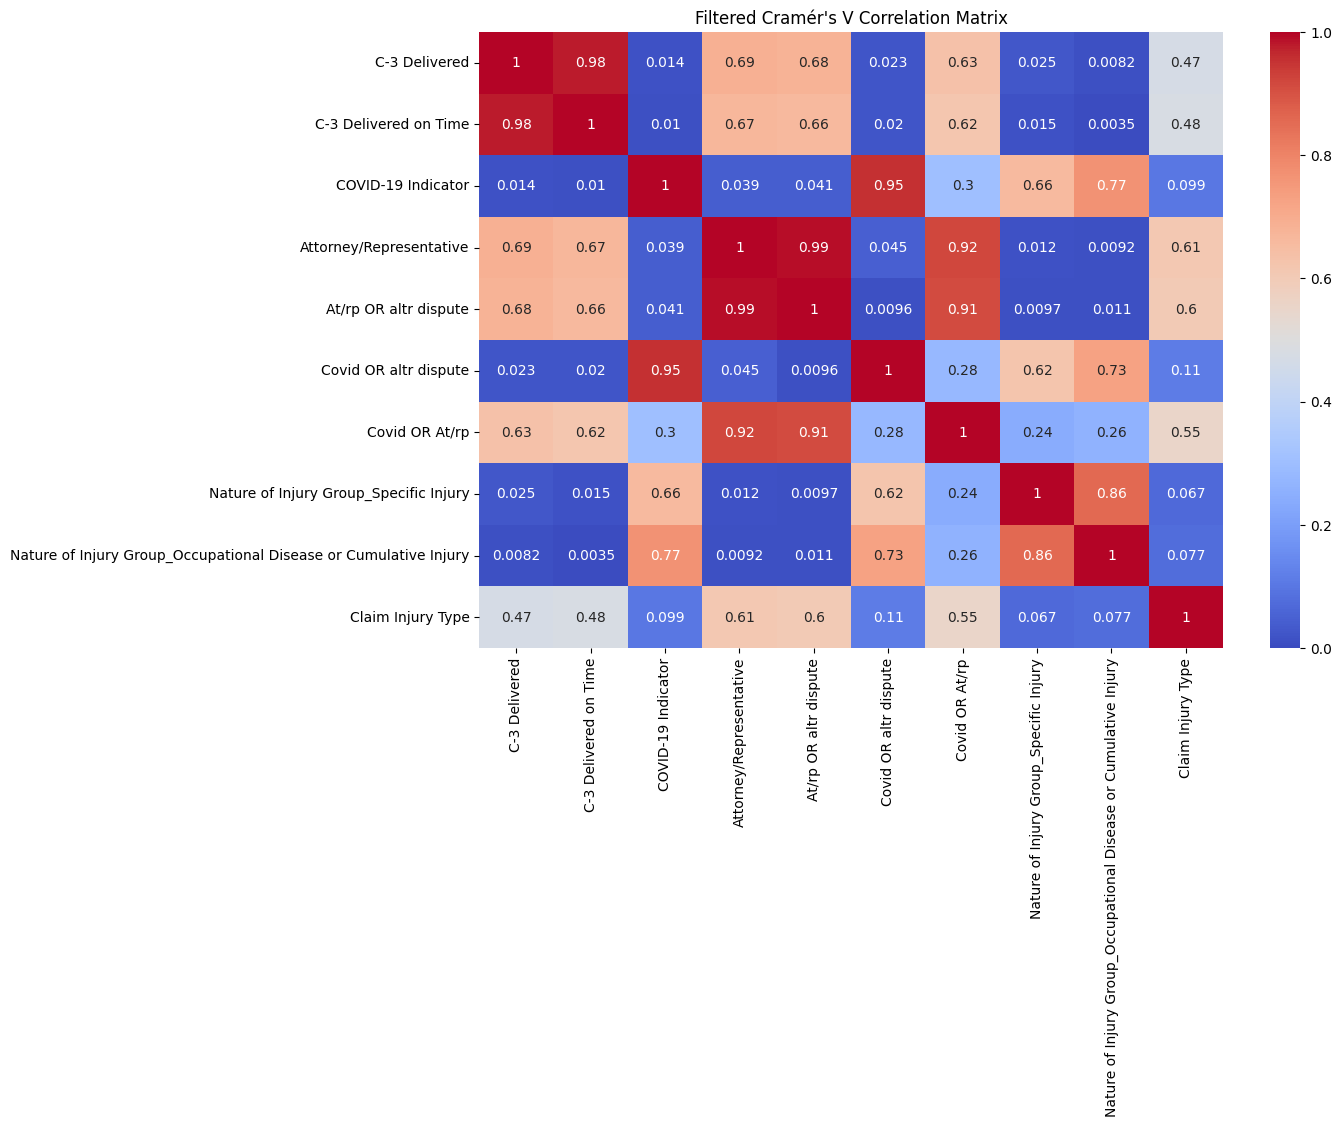

In [15]:
# Plot redundant features to see the correlation with the target

selected_columns = [
    "C-3 Delivered", "C-3 Delivered on Time", "COVID-19 Indicator",
    "Attorney/Representative", "At/rp OR altr dispute", "Covid OR altr dispute",
    "Covid OR At/rp", "Nature of Injury Group_Specific Injury",
    "Nature of Injury Group_Occupational Disease or Cumulative Injury", 
    "Claim Injury Type"  # Target variable
]

# Filter Cramér's V matrix
filtered_cramers_v_matrix = cramers_v_matrix.loc[selected_columns, selected_columns]

# Plot the filtered heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_cramers_v_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Filtered Cramér's V Correlation Matrix")
plt.show()

- `C_3 Delivered` VS. `C_3 Delivered on Time`: C-3 Delivered on Time has a slightly higher correlation with the target, we will discard C-3 delivered.
- `Attorney/Representative` VS. `At/rp Or altr dispute` & `Covir Or At/rp`: We will remove At/rp Or altr dispute and Covir Or At/rp because they have a lower correlation with the target.
- `COVID-19 Indicator` VS. `Covid Or Altr dispute`: Covid-19 Indicator has a lower correlation with the target so we will remove it
- `Nature of Injury Group_Occupational Disease or Cumulative Injury` VS. `Nature of Injury Group_Specific Injury`: We will remove Nature of Injury Group_Specific Injury for lower correlation with the target.

In [9]:
# Drop redundant to proceed with testing
X_train_preprocessed = X_train_preprocessed.drop([
    "C-3 Delivered", "At/rp OR altr dispute", "Covid OR At/rp", 
    "Nature of Injury Group_Specific Injury", "COVID-19 Indicator"
], axis=1)


Testing for pipeline implementation - defining thresholds:

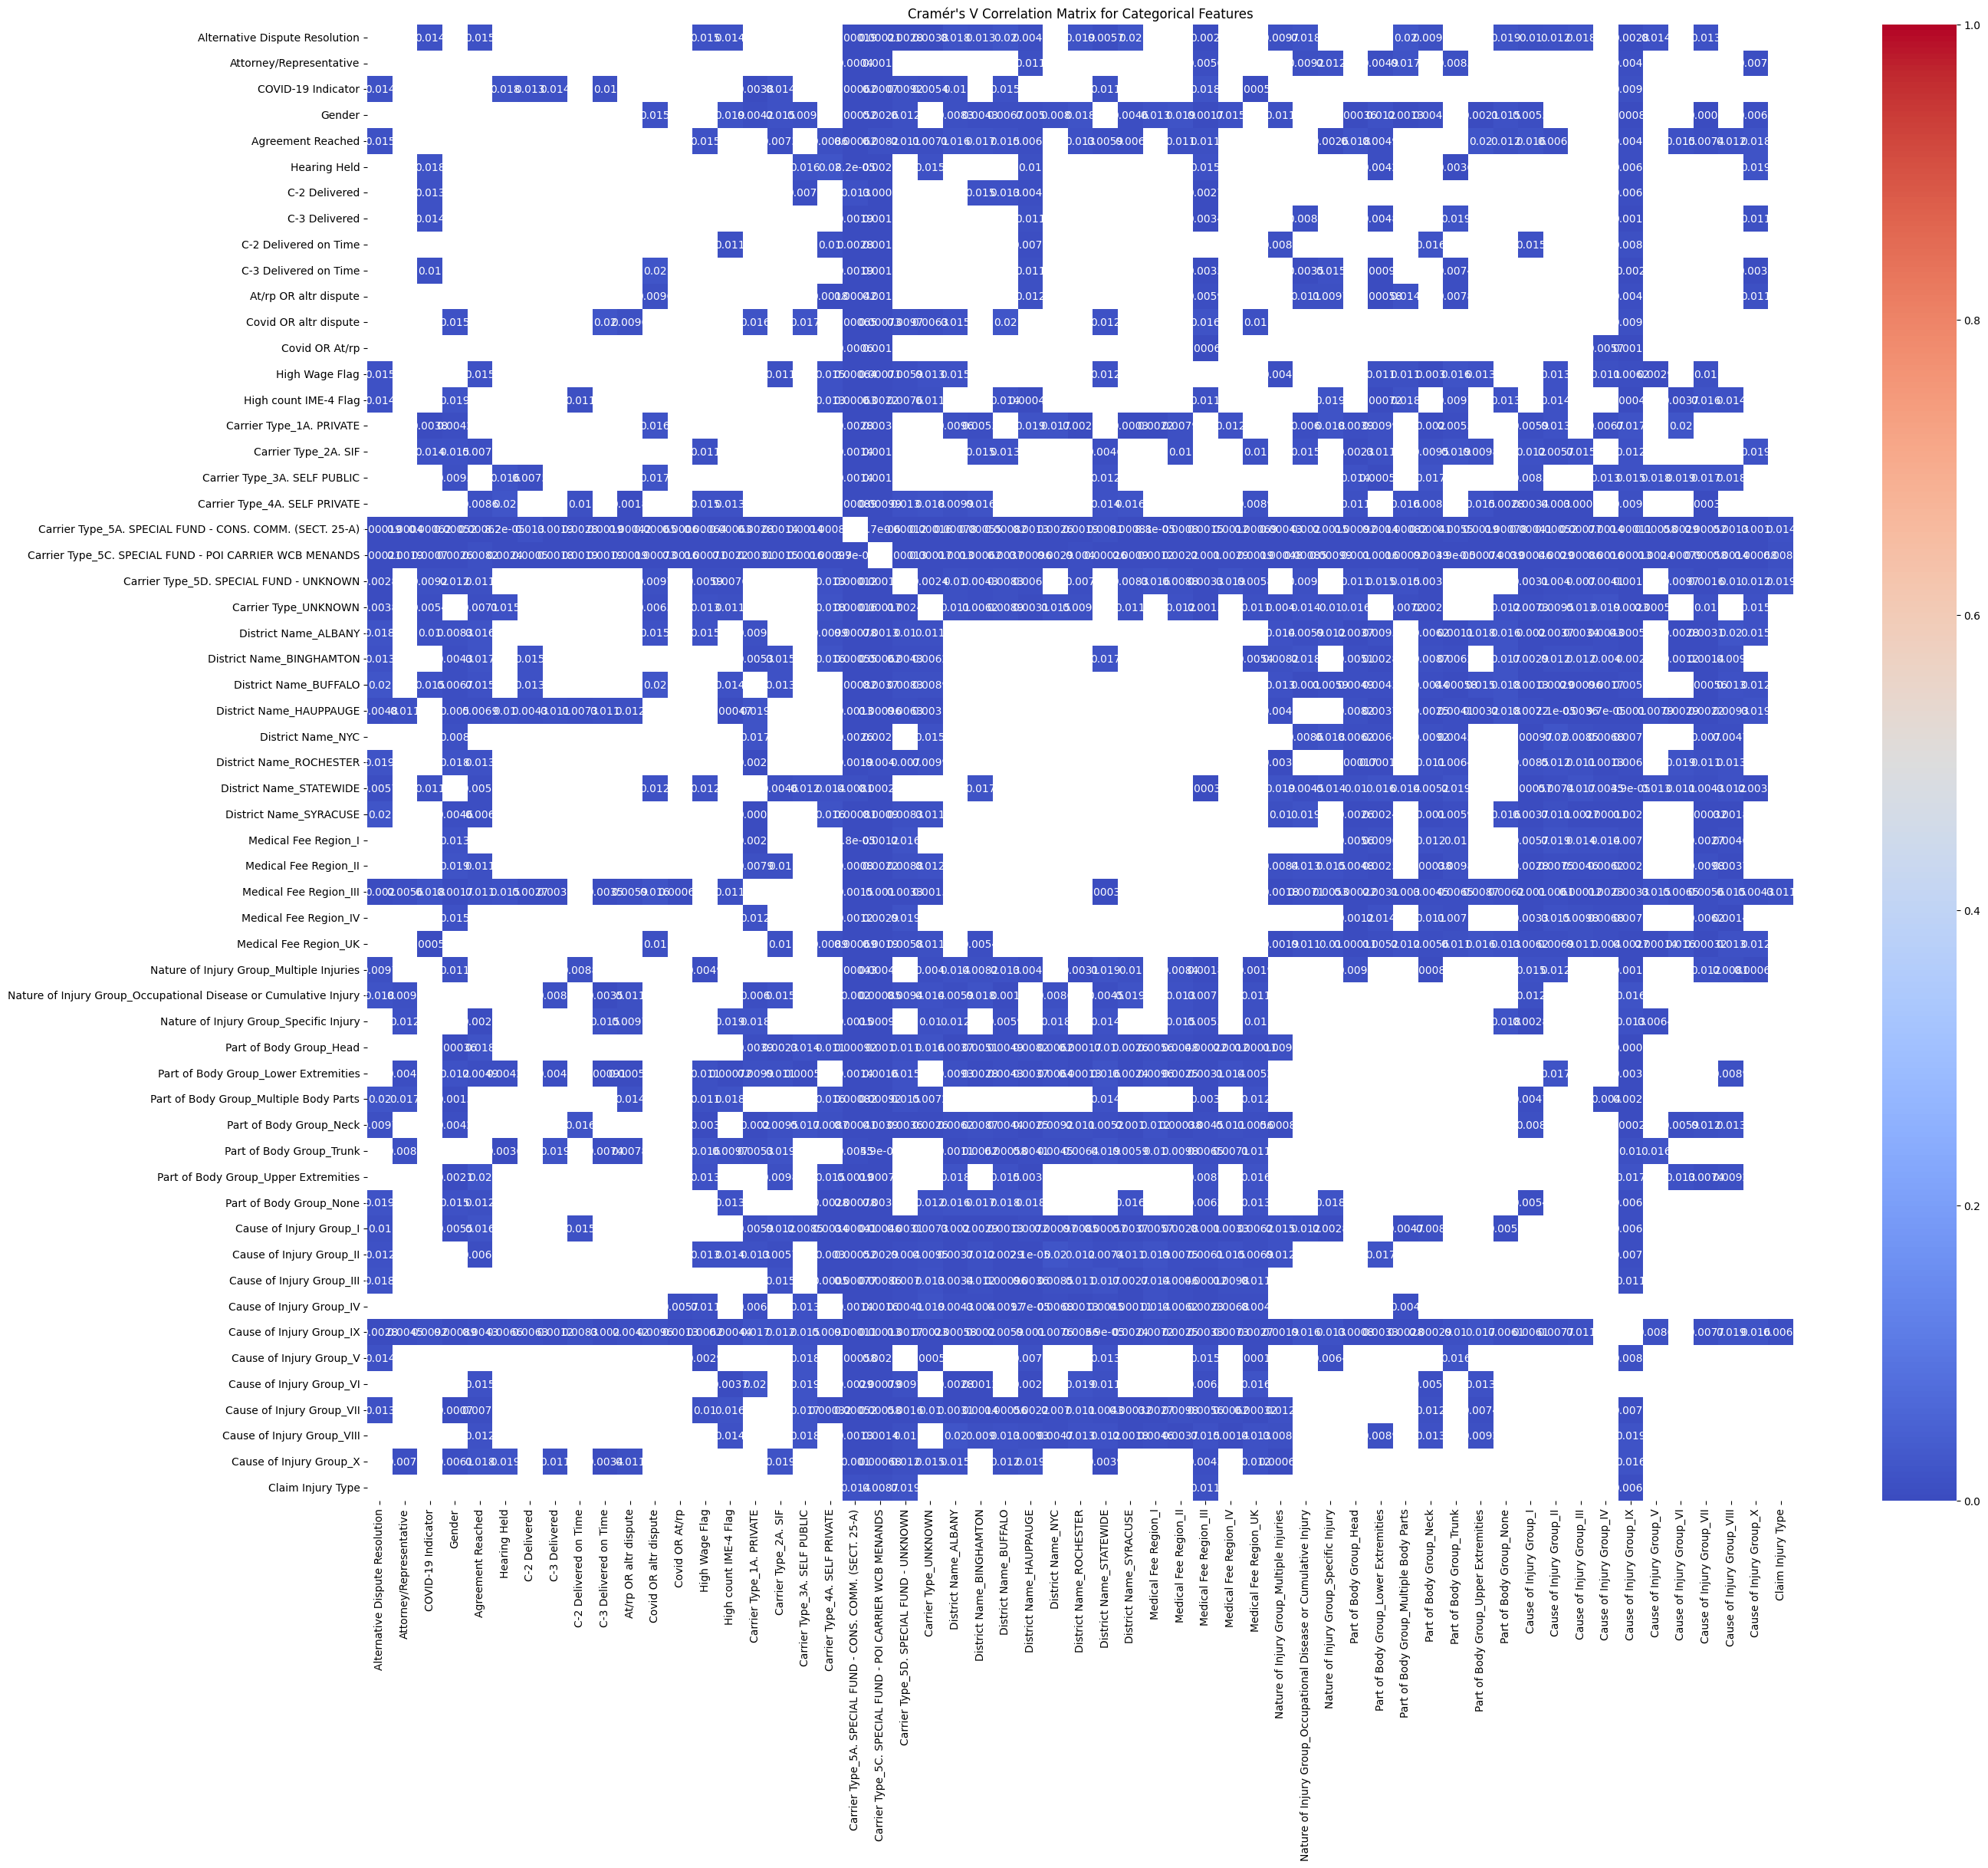

In [18]:
# Add the target variable to the non-metric features
data_non_metric = X_train_cat.copy()
data_non_metric['Claim Injury Type'] = y_train_encoded

def cramers_v(x, y):
    contingency = pd.crosstab(x, y).values
    chi2 = chi2_contingency(contingency, correction=False)[0]
    n = contingency.sum()
    r, k = contingency.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

def calculate_cramers_v_matrix(df):
    cols = df.columns
    n = len(cols)
    matrix = np.eye(n)  # Diagonal initialized to 1
    
    for i in range(n):
        for j in range(i + 1, n):  # Only calculate upper triangle
            v = cramers_v(df[cols[i]], df[cols[j]])
            matrix[i, j] = matrix[j, i] = v 
    return pd.DataFrame(matrix, columns=cols, index=cols)

# Calculate Cramér's V correlation matrix
cramers_v_matrix = calculate_cramers_v_matrix(data_non_metric)

# Apply threshold for irrelevance (< 0.02)
mask = ~(cramers_v_matrix < 0.02)

# Plot the heatmap
plt.figure(figsize=(30, 25)) 
sns.heatmap(cramers_v_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cramér's V Correlation Matrix for Categorical Features")
plt.show()

**Threshold of below 0.02 for irrelevance** - The Cramér's V matrix demonstrates that there are irrelevant variables, based on their correlation with the target:
- `Cause of Injury Group IX`, `Medical Fee Region III`, `Carrier Type_5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)`,
  and `Carrier Type_5C. SPECIAL FUND - POI CARRIER WCB MENANDS` are irrelevant given the very low correlation with the target.
- This implementation will be done on the pipeline to detected irrelevant features for a threshold of 0.02.

<a class="anchor" id="section_3_2">

## 3.2 Embedded Methods

</a>

Testing for pipeline implementation - defining thresholds and algorithms to use.

<a class="anchor" id="section_3_2_1">

### 3.2.1. Lasso Regression
    
</a>

In [10]:
# Initialize the Lasso model
reg = Lasso(alpha=0.01, random_state=random_state)

# Fit the model
reg.fit(X_train_preprocessed, y_train_encoded)

# Coefficients for each feature
coef = pd.Series(reg.coef_, index=X_train_preprocessed.columns)

# Apply threshold to filter features
threshold = 0.0  # Define threshold
filtered_coef = coef[abs(coef) > threshold]  

# Rank the selected features by importance
filtered_coef_sorted = filtered_coef.abs().sort_values(ascending=False)
lasso_rank = pd.DataFrame({
    'Feature': filtered_coef_sorted.index,
    'Rank_lasso': range(1, len(filtered_coef_sorted) + 1)  # Create ranking
})

# Print the ranking of features
print("Feature Rankings based on Lasso Coefficients:")
print(lasso_rank)

Feature Rankings based on Lasso Coefficients:
                                 Feature  Rank_lasso
0                          C-2 Delivered           1
1                Attorney/Representative           2
2                           Hearing Held           3
3                         High Wage Flag           4
4                  C-3 Delivered on Time           5
5   Part of Body Group_Lower Extremities           6
6               Cause of Injury Group_IV           7
7                      District Name_NYC           8
8   Part of Body Group_Upper Extremities           9
9               Cause of Injury Group_VI          10
10                     Agreement Reached          11
11               Cause of Injury Group_X          12
12                 C-2 Delivered on Time          13
13                  Carrier Type_2A. SIF          14
14                         Assembly Year          15
15                                Gender          16
16             Cause of Injury Group_III          17


- Alpha set to 0.01 results in a appropriate number of features for the ranking.
- We will only consider features that had an above 0.0 coefficient.


<a class="anchor" id="section_3_2_2">

### 3.2.2. Decision Tree
    
</a>

In [11]:
# Fit the Decision Tree model using entropy as criterion
tree_importance = DecisionTreeClassifier(criterion='entropy', random_state=random_state)
tree_importance.fit(X_train_preprocessed, y_train_encoded)

# Get feature importances
importance = pd.DataFrame(tree_importance.feature_importances_, 
                          index=X_train_preprocessed.columns, 
                          columns=['Importance'])

# Set threshold for importance 
threshold = 0.01

# Filter features based on importance
filtered_importance = importance[importance['Importance'] > threshold]

# Sort features by importance and assign ranks
decision_tree_rank = (
    filtered_importance
    .sort_values(by='Importance', ascending=False)
    .reset_index()  # Keep feature names as a column
)

# Rename the column containing feature names
decision_tree_rank.rename(columns={'index': 'Feature'}, inplace=True)

# Add rank column
decision_tree_rank['Rank_decision_tree'] = range(1, len(filtered_importance) + 1)

# Print the DataFrame with features and their ranks
print("Ranked Features based on Decision Tree Importance:")
print(decision_tree_rank)


Ranked Features based on Decision Tree Importance:
                      Feature  Importance  Rank_decision_tree
0     Average Weekly Wage Log    0.214699                   1
1     Attorney/Representative    0.156182                   2
2               Age at Injury    0.078101                   3
3   Time Accident to Assembly    0.076870                   4
4               Industry Code    0.073024                   5
5    Time Assembly to Hearing    0.056288                   6
6            County of Injury    0.032705                   7
7           Agreement Reached    0.031493                   8
8               C-2 Delivered    0.030619                   9
9             IME-4 Count Log    0.024935                  10
10               Carrier Name    0.021151                  11
11              Assembly Year    0.020971                  12
12   Part of Body Group_Trunk    0.013151                  13
13                     Gender    0.010823                  14


- We will define a threshold of 0.01 for the minimum importance a feature should have to be in considered for the ranking of the algorithm.
- For criterion we will use entropy.


<a class="anchor" id="section_3_2_3">

### 3.2.3. XGBoost
    
</a>

In [12]:
# Initialize the XGBoost model
xgb_importance = XGBClassifier(random_state=random_state)

# Fit the XGBoost model
xgb_importance.fit(X_train_preprocessed, y_train_encoded)

# Get feature importances
importance = pd.DataFrame(xgb_importance.feature_importances_, 
                          index=X_train_preprocessed.columns, 
                          columns=['Importance'])

# Set threshold for importance
threshold = 0.01

# Filter features based on importance
filtered_importance = importance[importance['Importance'] > threshold]

# Sort features by importance and assign ranks
xgboost_rank = (
    filtered_importance
    .sort_values(by='Importance', ascending=False)
    .reset_index()  # Keep feature names as a column
)

# Rename the column containing feature names
xgboost_rank.rename(columns={'index': 'Feature'}, inplace=True)

# Add rank column
xgboost_rank['Rank_xgboost'] = range(1, len(filtered_importance) + 1)

# Print the DataFrame with features and their ranks
print("Ranked Features based on XGBoost Importance:")
print(xgboost_rank)


Ranked Features based on XGBoost Importance:
                                   Feature  Importance  Rank_xgboost
0                  Attorney/Representative    0.238293             1
1                        Agreement Reached    0.154485             2
2                            C-2 Delivered    0.140128             3
3                  Average Weekly Wage Log    0.042185             4
4                 Part of Body Group_Trunk    0.029461             5
5                            Industry Code    0.024735             6
6                     Carrier Type_UNKNOWN    0.023449             7
7                    C-2 Delivered on Time    0.023382             8
8                 Time Assembly to Hearing    0.021810             9
9                    Covid OR altr dispute    0.021645            10
10                            Hearing Held    0.020292            11
11                         IME-4 Count Log    0.019829            12
12                   C-3 Delivered on Time    0.014781    

- We will define a threshold of 0.01 for the minimum importance a feature should have to be in considered for the ranking of the algorithm.

<a class="anchor" id="section_3_3">

## 3.3 Final Ranking

</a>

In [14]:
# Combine the rankings from the three models using outer join
combined_rank = (lasso_rank
                 .merge(decision_tree_rank, on='Feature', how='outer')
                 .merge(xgboost_rank, on='Feature', how='outer'))

# Count the number of rankings where a feature appears
combined_rank['Ranking_Count'] = combined_rank[['Rank_lasso', 'Rank_decision_tree', 'Rank_xgboost']].notnull().sum(axis=1)

# Filter features that appear in at least 2 rankings
filtered_rank = combined_rank[combined_rank['Ranking_Count'] >= 2]


# Calculate the average rank across available rankings
filtered_rank['Total_Rank'] = filtered_rank[['Rank_lasso', 'Rank_decision_tree', 'Rank_xgboost']].replace(0, np.nan).mean(axis=1)

# Order the features by the final average rank
final_rank = filtered_rank.sort_values(by='Total_Rank').reset_index(drop=True)


/var/folders/fl/gygf4vxd5dz_9chtfs_f8n000000gn/T/ipykernel_18775/1874446816.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rank['Total_Rank'] = filtered_rank[['Rank_lasso', 'Rank_decision_tree', 'Rank_xgboost']].replace(0, np.nan).mean(axis=1)


In [15]:
# Display the result
print(final_rank)

                                 Feature  Rank_lasso  Importance_x  \
0                Attorney/Representative         2.0      0.156182   
1                Average Weekly Wage Log         NaN      0.214699   
2                          C-2 Delivered         1.0      0.030619   
3                          Industry Code         NaN      0.073024   
4                      Agreement Reached        11.0      0.031493   
5                           Hearing Held         3.0           NaN   
6               Time Assembly to Hearing         NaN      0.056288   
7               Part of Body Group_Trunk         NaN      0.013151   
8                  C-3 Delivered on Time         5.0           NaN   
9                  C-2 Delivered on Time        13.0           NaN   
10  Part of Body Group_Lower Extremities         6.0           NaN   
11                       IME-4 Count Log         NaN      0.024935   
12  Part of Body Group_Upper Extremities         9.0           NaN   
13                  

- For the final ranking we will consider features that are present in at least 2 rankings and sum their positions on the rankings to obtain the final rank position. 